# Branded QR Notebook
This notebook uses assets stored under `data/` for logos and saves outputs under `data/` as well.

Presets available: `mq`, `unisq`, `sydney`, `uq`. Default logo size increased by ~30% for better balance.

- MQ: `data/mq_colour.png`
- UniSQ: `data/unisq_shield_plain.png`
- Sydney: `data/sydlogo.png`
- UQ: `data/uqlogo.png`

In [156]:
# import modules
import segno
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Configuration for logo compositing
__version__ = "0.1.1"  # Version of the branded QR generator

target_frac = 0.18       # smaller logo: fraction of QR width
pad_frac = 0.28          # larger circular padding around logo
smooth_sigma = 1.2       # stronger Gaussian blur on circle edge
ring_thickness = 0       # disable ring border
ring_color = (200, 200, 200, 255)  # unused when thickness=0
module_radius_frac = 0.4 # rounded corner radius relative to module size

In [ ]:
def make_branded_qr(
    url: str,
    logo_path: str,
    *,
    target_frac: float = 0.18,
    pad_frac: float = 0.28,
    smooth_sigma: float = 1.2,
    ring_thickness: int = 0,
    ring_color: tuple = (200, 200, 200, 255),
    qr_scale: int = 10,
    border_modules: int = 4,
    error: str = 'h',
    data_dark: str = 'black',
    finder_from_logo: bool = True,
    finder_dark_color: str | None = None,
    module_shape: str = 'circle',
    edge_clearance: float = 1.0,
    save_path: str | None = None,
):
    """Generate a branded QR code with a circular inset and logo.

    Version: 0.1.1

    Minimal Usage:
    - img = make_branded_qr(url="https://example.com", logo_path="logo.png")
    - For UniSQ branding, prefer finder_dark_color="\u00233c2d4d".

    Parameters
    - url: target URL/text encoded into the QR.
    - logo_path: path to the logo image file.
    - target_frac: fraction of final QR width used for logo.
    - pad_frac: fraction of logo width used for white circular padding.
    - smooth_sigma: Gaussian blur for circle edge softness.
    - ring_thickness: optional outline width for the circle (0 disables).
    - ring_color: outline RGBA color.
    - qr_scale: pixel size per module.
    - border_modules: quiet-zone size in modules.
    - error: segno error-correction level (e.g., 'l','m','q','h').
    - data_dark: color for data modules (e.g., 'black' or '#RRGGBB').
    - finder_from_logo: when True, sample darkest color from logo for finder marks.
    - finder_dark_color: explicit finder dark color (e.g., '#802020'); overrides sampling.
    - module_shape: 'circle' or 'square' for data modules.
    - edge_clearance: multiplier for skipping dots overlapping the inset edge.
    - save_path: optional output filename; if provided, image is saved.

    Notes
    - UniSQ branding: set finder_dark_color to "\u00233c2d4d" for consistency.

    Returns: PIL.Image.Image of the composed QR.
    """
    import segno, io
    from PIL import Image, ImageDraw, ImageFilter
    import numpy as np

    sg_qr = segno.make(url, error=error)
    try:
        mat = sg_qr.matrix
    except AttributeError:
        mat = sg_qr.to_matrix()
    n = len(mat)

    # Output image width in pixels
    img_w = (n + 2 * border_modules) * qr_scale

    # Load and resize logo
    logo_rgba = Image.open(logo_path).convert('RGBA')
    w, h = logo_rgba.size
    target_w = int(img_w * target_frac)
    scale = target_w / max(1, w)
    new_w = max(1, target_w)
    new_h = max(1, int(h * scale))
    new_logo = logo_rgba.resize((new_w, new_h), Image.LANCZOS)

    # Determine finder dark color
    if finder_dark_color is not None:
        finder_dark_hex = finder_dark_color
    else:
        def luminance(c):
            r, g, b = c
            return 0.2126 * r + 0.7152 * g + 0.0722 * b
        if finder_from_logo:
            logo_small = new_logo.convert('RGB').resize((64, 64), Image.LANCZOS)
            colors = logo_small.getcolors(64 * 64) or []
            rgb_colors = [col for cnt, col in colors] if colors else [tuple(p) for p in logo_small.getdata()]
            filtered = [c for c in rgb_colors if luminance(c) < 245] or rgb_colors
            darkest = sorted(set(filtered), key=luminance)[0]
            finder_dark_hex = '#{:02x}{:02x}{:02x}'.format(*darkest)
        else:
            finder_dark_hex = 'black'

    # Build circular background
    pad = max(8, int(new_w * pad_frac))
    diameter = max(new_w, new_h) + 2 * pad
    bg_size = (diameter, diameter)
    circle_radius = diameter // 2
    bg_center = (img_w // 2, img_w // 2)

    bg = Image.new('RGBA', bg_size, (255, 255, 255, 0))
    circle_mask = Image.new('L', bg_size, 0)
    draw_mask = ImageDraw.Draw(circle_mask)
    draw_mask.ellipse((0, 0, diameter, diameter), fill=255)
    circle_mask = circle_mask.filter(ImageFilter.GaussianBlur(smooth_sigma))
    white_circle = Image.new('RGBA', bg_size, (255, 255, 255, 255))
    bg = Image.composite(white_circle, bg, circle_mask)

    if ring_thickness > 0:
        ring_layer = Image.new('RGBA', bg_size, (0, 0, 0, 0))
        ring_draw = ImageDraw.Draw(ring_layer)
        inset = ring_thickness / 2
        ring_draw.ellipse((inset, inset, diameter - inset, diameter - inset),
                          outline=ring_color, width=ring_thickness)
        bg = Image.alpha_composite(bg, ring_layer)

    # Centroid placement for logo visual mass
    arr = np.array(new_logo)
    rgb = arr[..., :3].astype(np.float32)
    alpha = arr[..., 3]
    lum = 0.2126 * rgb[..., 0] + 0.7152 * rgb[..., 1] + 0.0722 * rgb[..., 2]
    fg = (alpha > 10) & (lum < 245)
    if fg.any():
        ys, xs = np.nonzero(fg)
        cx_logo = xs.mean()
        cy_logo = ys.mean()
    else:
        cx_logo = new_w / 2
        cy_logo = new_h / 2
    base_x = (diameter - new_w) // 2
    base_y = (diameter - new_h) // 2
    offset_x = int(round(new_w / 2 - cx_logo))
    offset_y = int(round(new_h / 2 - cy_logo))
    paste_x = max(0, min(diameter - new_w, base_x + offset_x))
    paste_y = max(0, min(diameter - new_h, base_y + offset_y))
    bg.paste(new_logo, (paste_x, paste_y), new_logo)

    # Render QR modules
    QRimg = Image.new('RGB', (img_w, img_w), 'white')
    draw = ImageDraw.Draw(QRimg)
    module_radius = qr_scale / 2.0
    circle_cx, circle_cy = bg_center

    def in_finder(x, y, size):
        return ((x < 7 and y < 7) or (x >= size - 7 and y < 7) or (x < 7 and y >= size - 7))

    for y in range(n):
        for x in range(n):
            if mat[y][x]:
                px = (x + border_modules) * qr_scale
                py = (y + border_modules) * qr_scale
                mx = px + module_radius
                my = py + module_radius
                d = ((mx - circle_cx) ** 2 + (my - circle_cy) ** 2) ** 0.5
                is_finder = in_finder(x, y, n)
                color = finder_dark_hex if is_finder else data_dark
                if not is_finder and abs(d - circle_radius) < edge_clearance * module_radius:
                    continue
                if is_finder:
                    draw.rectangle([px, py, px + qr_scale - 1, py + qr_scale - 1], fill=color)
                else:
                    if module_shape == 'circle':
                        draw.ellipse([px, py, px + qr_scale - 1, py + qr_scale - 1], fill=color)
                    else:
                        draw.rectangle([px, py, px + qr_scale - 1, py + qr_scale - 1], fill=color)

    # Paste circular background centered
    pos = (bg_center[0] - circle_radius, bg_center[1] - circle_radius)
    QRimg.paste(bg, (int(pos[0]), int(pos[1])), bg.split()[-1])

    if save_path:
        QRimg.save(save_path)
    return QRimg

In [ ]:
fname = 'data/mq_colour.png'
# taking image which user wants 
# in the QR code center


logo = Image.open(fname).convert('RGBA')
# we'll size and add circular background later based on QR size
# logo

In [ ]:

# taking url or text
url = 'https://aas.org/jobregister/ad/82a27270/'

# scale logo to a fraction of QR width later; first resize logo
# We'll build the QR with segno using high error correction
logo_rgba = logo.convert('RGBA')

import io
import segno
sg_qr = segno.make(url, error='h')

# Choose a scale so the QR is a reasonable size
qr_scale = 10
border_modules = 4  # quiet zone in modules

# Build a base matrix via segno
try:
    mat = sg_qr.matrix
except AttributeError:
    mat = sg_qr.to_matrix()
n = len(mat)  # number of modules per side

# Determine darkest color in the resized logo to color finder patterns
def luminance(c):
    r, g, b = c
    return 0.2126*r + 0.7152*g + 0.0722*b

# Compute output image width in pixels
img_w = (n + 2*border_modules) * qr_scale

# Resize logo proportionally based on target output width
target_w = int(img_w * target_frac)
w, h = logo_rgba.size
scale = target_w / max(1, w)
new_w = max(1, target_w)
new_h = max(1, int(h * scale))
new_logo = logo_rgba.resize((new_w, new_h), Image.LANCZOS)

# Sample palette from resized logo
logo_small = new_logo.convert('RGB').resize((64, 64), Image.LANCZOS)
colors = logo_small.getcolors(64*64) or []
rgb_colors = [col for cnt, col in colors] if colors else [tuple(p) for p in logo_small.getdata()]
filtered = [c for c in rgb_colors if luminance(c) < 245] or rgb_colors
sorted_cols = sorted(set(filtered), key=luminance)
darkest = sorted_cols[0]
finder_dark_hex = '#{:02x}{:02x}{:02x}'.format(*darkest)

# Build circular background (perfect circle)
pad = max(8, int(new_w * pad_frac))
diameter = max(new_w, new_h) + 2 * pad
bg_size = (diameter, diameter)
bg_center = (img_w // 2, img_w // 2)
circle_radius = diameter // 2

# transparent base
bg = Image.new('RGBA', bg_size, (255, 255, 255, 0))

# white circle using a smoothed mask
circle_mask = Image.new('L', bg_size, 0)
draw_mask = ImageDraw.Draw(circle_mask)
draw_mask.ellipse((0, 0, diameter, diameter), fill=255)
circle_mask = circle_mask.filter(ImageFilter.GaussianBlur(smooth_sigma))
white_circle = Image.new('RGBA', bg_size, (255, 255, 255, 255))
bg = Image.composite(white_circle, bg, circle_mask)

# optional ring outline
if ring_thickness > 0:
    ring_layer = Image.new('RGBA', bg_size, (0, 0, 0, 0))
    ring_draw = ImageDraw.Draw(ring_layer)
    inset = ring_thickness / 2
    ring_draw.ellipse((inset, inset, diameter-inset, diameter-inset),
                      outline=ring_color, width=ring_thickness)
    bg = Image.alpha_composite(bg, ring_layer)

# Compute centroid of logo foreground to center by visual mass
import numpy as np
arr = np.array(new_logo)
rgb = arr[..., :3].astype(np.float32)
alpha = arr[..., 3]
lum = 0.2126*rgb[...,0] + 0.7152*rgb[...,1] + 0.0722*rgb[...,2]
fg = (alpha > 10) & (lum < 245)
if fg.any():
    ys, xs = np.nonzero(fg)
    cx_logo = xs.mean()
    cy_logo = ys.mean()
else:
    cx_logo = new_w / 2
    cy_logo = new_h / 2

# paste logo centered inside circle with centroid correction
base_x = (diameter - new_w) // 2
base_y = (diameter - new_h) // 2
offset_x = int(round(new_w/2 - cx_logo))
offset_y = int(round(new_h/2 - cy_logo))
paste_x = max(0, min(diameter - new_w, base_x + offset_x))
paste_y = max(0, min(diameter - new_h, base_y + offset_y))
bg.paste(new_logo, (paste_x, paste_y), new_logo)

# Prepare final QR image canvas
QRimg = Image.new('RGB', (img_w, img_w), 'white')
draw = ImageDraw.Draw(QRimg)

# Determine circle center in QR coordinate space
circle_cx = bg_center[0]
circle_cy = bg_center[1]

# Render modules: finder squares, data circles; skip overlaps with inset
module_radius = qr_scale / 2.0
for y in range(n):
    for x in range(n):
        if mat[y][x]:
            px = (x + border_modules) * qr_scale
            py = (y + border_modules) * qr_scale
            mx = px + module_radius
            my = py + module_radius
            d = ((mx - circle_cx)**2 + (my - circle_cy)**2) ** 0.5
            is_finder = ((x < 7 and y < 7) or (x >= n-7 and y < 7) or (x < 7 and y >= n-7))
            color = finder_dark_hex if is_finder else 'black'
            if not is_finder and abs(d - circle_radius) < module_radius:
                continue
            if is_finder:
                draw.rectangle([px, py, px + qr_scale - 1, py + qr_scale - 1], fill=color)
            else:
                draw.ellipse([px, py, px + qr_scale - 1, py + qr_scale - 1], fill=color)

# Paste circular background centered
pos = (bg_center[0] - circle_radius, bg_center[1] - circle_radius)
QRimg.paste(bg, (int(pos[0]), int(pos[1])), bg.split()[ -1])

# save the QR code generated
QRimg.save('data/aas_QR.png')

print('QR code generated!')

QR code generated!


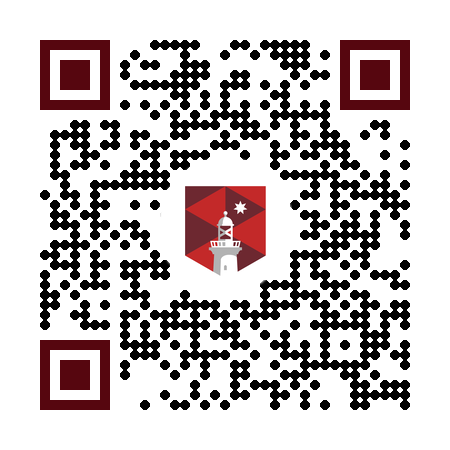

In [173]:
QRimg

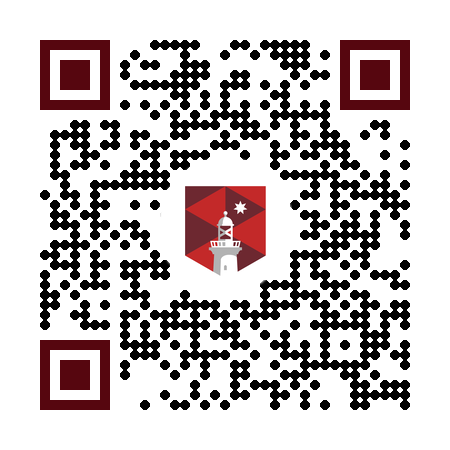

In [ ]:
# Demo: build a QR with current defaults
img = make_branded_qr(
    url='https://aas.org/jobregister/ad/82a27270/',
    logo_path='data/mq_colour.png',
    save_path='data/aas_QR.png'
 )
img

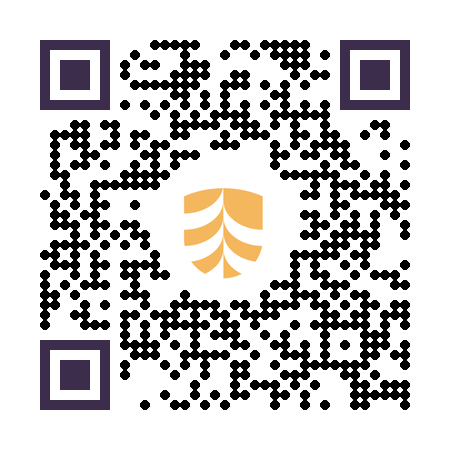

In [ ]:
# Demo: build a QR with current defaults
# UniSQ branding prefers finder_dark_color="#3c2d4d"
img2 = make_branded_qr(
    url='https://aas.org/jobregister/ad/82a27270/',
    logo_path='data/unisq_shield_plain.png',
    save_path='data/aas_QR.png',
    finder_dark_color="#3c2d4d"
 )
img2

In [ ]:
# Demo using university preset
img3 = make_branded_qr(
    url='https://aas.org/jobregister/ad/82a27270/',
    university='mq',
    save_path='data/aas_QR.png'
 )
img3

In [ ]:
# Demo using UQ preset
img4 = make_branded_qr(
    url='https://uq.edu.au',
    university='uq',
    save_path='data/aas_QR.png'
 )
img4